# Semantic Segmentation with Captum - GradientSHAP

### Imports all necessary packages

In [1]:
# If working on colab

#  1. uncomment the following:
# %pip install ipywidgets ipyleaflet ipympl -q
# %pip install captum zarr geopandas shapely -q
# %pip install rioxarray -q
# from google.colab import drive
# drive.mount('/content/drive')
# !cp "../utils/plots.py" .
# !cp "../utils/model.py" .
# !cp "../utils/dataloader.py" .
# import utils

#  2. comment the following:
%cd ../..
import utils

/home/gpaolini/Documents/CODE/noa-xai-for-wildfire-forecasting


In [4]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import xarray as xr
from pathlib import Path
import zarr
import pandas as pd
from scipy import stats
from tqdm.notebook import tqdm as ntqdm
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
from captum.attr import GradientShap
import rioxarray, rasterio
from rasterio.warp import reproject
from rasterio.enums import Resampling
from io import BytesIO

%matplotlib widget
# interactive visualization
import ipyleaflet, ipywidgets, matplotlib.pyplot as plt
import PIL
from base64 import b64encode
from ipyleaflet import Map, ImageOverlay, basemap_to_tiles, basemaps

# Default device
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
train_on_gpu = torch.cuda.is_available()
print(f"GPU available? {train_on_gpu}")
SEED = 172
MODEL_NO = 0  # in K-fold
N_FOLDS = 10  # in K-fold
utils.seed_everything(SEED)

GPU available? False


## Load dataset
Here we load the test dataset in chuncks of 90x90 pixels. 

Since we are loading all the data into memory  (in order to be more computationally efficient later), we are careful on just loading the chunks that contains at least 1 burned pixel, to save RAM space (it will require around 7 Gb). 


It is possible to modify this behaviour if less space is available just calling a smaller time slice in "utils.create_datasets_model" or doing a lazy loading (necessary to modify the "utils.dataloader.FireDataset")

In [4]:
### INPUTS
### if using colab:
# 1. uncomment this lines:
# ds = xr.open_zarr('/content/drive/MyDrive/seasfire.zarr')
# file_mean_std = '/content/drive/MyDrive/challenge - NOA - XAI for Wildfire Forecasting/Notebooks/develop_Giovanni/table_mean_std.csv'
# GFED_file = "/content/drive/MyDrive/challenge - NOA - XAI for Wildfire Forecasting/Data/Biomes_and_GFED/GFED_basis_regions.nc"
# biomes_file = "/content/drive/MyDrive/challenge - NOA - XAI for Wildfire Forecasting/Data/Biomes_and_GFED/biomes.nc"
# file_global_delta1 = "/content/drive/MyDrive/challenge - NOA - XAI for Wildfire Forecasting/Models checkpoints/NEW_unet_ml_7vars_log_tp_popdens_delta1ts_GLOBAL_2001_2016.pt"
# 2. comment this lines:
ds = xr.open_zarr("/data/seasfire.zarr")  # the datacube must be stired in "data folder"
file_mean_std = "/data/table_mean_std_7vars_binarysegmentation.csv"
GFED_file = "/data/Biomes_and_GFED/GFED_basis_regions.nc"
biomes_file = "/data/Biomes_and_GFED/biomes.nc"
file_global_delta1 = (
    "/models/NEW_unet_ml_7vars_log_tp_popdens_delta1ts_GLOBAL_2001_2016.pt"
)

## PROCESSING
mask_water = xr.where(ds.lsm >= 0.9, 1, 0).astype(bool)

ds = ds.assign(pop_dens_LOG=lambda x: np.log(1 + x["pop_dens"]))
ds = ds.assign(tp_LOG=lambda x: np.log(1 + x["tp"]))

variables_selected = [
    "rel_hum",
    "ndvi",
    "pop_dens_LOG",
    "lsm",
    "tp_LOG",
    "gwis_ba",
    "sst",
    "lst_day",
]

if not Path(file_mean_std).exists():
    ### SAVE IN A TABLE GLOBAL MEAN AND STD for EACH VARIABLE
    vmean = ds.mean()[variables_selected].load().to_pandas()
    vmean.name = "mean"
    vstd = ds.std()[variables_selected].load().to_pandas()
    vstd.name = "std"
    table_mean_std = pd.concat([vmean, vstd], axis=1)
    table_mean_std.to_csv(file_mean_std)
else:
    table_mean_std = pd.read_csv(file_mean_std, index_col=0, header=0)

ds = ds.chunk(dict(time=len(ds.time), latitude=90, longitude=90))

*__, test_dataset = utils.create_datasets_model(
    ds[variables_selected],
    slice_train=None,
    slice_valid=None,
    slice_test=slice("20190101", "20201231"),
    table_mean_std=table_mean_std,
    target="gwis_ba",
    delta_time=1,
    inland_map=mask_water,
)
test_dataset.dx = test_dataset.dx.astype(np.float32)

num_workers = 0
bs = 4
test_loader = DataLoader(
    test_dataset, batch_size=bs, shuffle=False, num_workers=num_workers
)

check on chuncks with fire:   0%|          | 0/8 [00:00<?, ?it/s]

out of 11776 chuncks, 4005 have at least 1 fire pixel (34.01%)


loading in memory:   0%|          | 0/69 [00:00<?, ?it/s]

### Read Biomes

[Text(0.5, 1.0, 'biomes')]

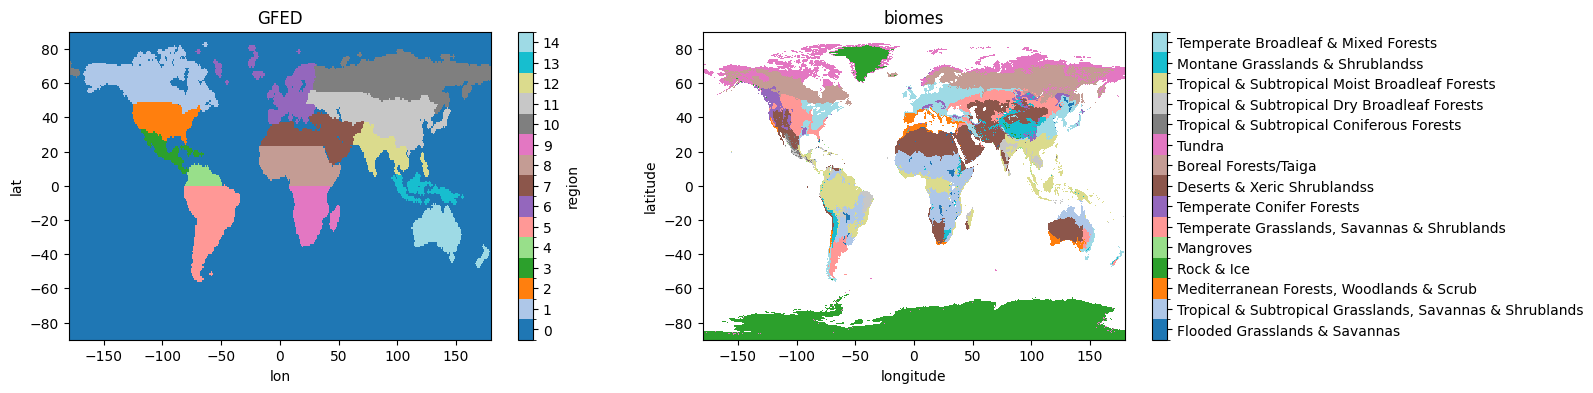

In [6]:
# read biomes (0.25 deg)
dd_bio = xr.open_dataset(biomes_file)
# read gfed (1 deg) and interpolate like biomes (0.25 deg)
dd_gfed = xr.open_dataset(GFED_file).interp_like(dd_bio, method="nearest")
dict_biomes = dict(
    [
        (1, "Flooded Grasslands & Savannas"),
        (2, "Tropical & Subtropical Grasslands, Savannas & Shrublands"),
        (3, "Mediterranean Forests, Woodlands & Scrub"),
        (4, "Rock & Ice"),
        (5, "Mangroves"),
        (6, "Temperate Grasslands, Savannas & Shrublands"),
        (7, "Temperate Conifer Forests"),
        (8, "Deserts & Xeric Shrublandss"),
        (9, "Boreal Forests/Taiga"),
        (10, "Tundra"),
        (11, "Tropical & Subtropical Coniferous Forests"),
        (12, "Tropical & Subtropical Dry Broadleaf Forests"),
        (13, "Tropical & Subtropical Moist Broadleaf Forests"),
        (14, "Montane Grasslands & Shrublandss"),
        (15, "Temperate Broadleaf & Mixed Forests"),
    ]
)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
dd_gfed.region.plot(
    ax=axs[0],
    cmap="tab20",
    levels=np.concatenate([[-0.5], np.unique(dd_gfed.region) + 0.5]),
    cbar_kwargs={"ticks": list(range(15)), "spacing": "proportional"},
)

im = dd_bio.biomes.plot.imshow(
    ax=axs[1],
    cmap="tab20",
    levels=np.array([0] + list(dict_biomes.keys())) + 0.5,
    add_colorbar=False,
)
cb = plt.colorbar(im, ticks=list(dict_biomes.keys()), spacing="proportional")
cb.set_ticklabels(list(dict_biomes.values()))
axs[0].set(title="GFED")
axs[1].set(title="biomes")

The object "test_dataset" contains now a dataframe with the list of accepted chucks ("test_dataset.accepted_slices") that indicetes the position in time and lat/lon of each selected chunks. 

Here we add a few columns to the dataframe to have a stats on what is the most prevalent biome that is burnt.

In [ ]:
%%capture --no-display


def modefun(x, biomes):
    xc, yc = (x > 0).nonzero()
    u = biomes[xc, yc]
    u = u[~np.isnan(u)]
    return stats.mode(u, keepdims=True)


new_acc_slices = test_dataset.accepted_slices.copy()
for kk, gp in new_acc_slices.groupby("chunk_nbr"):
    biomes = dd_bio.biomes.isel(gp[["latitude", "longitude"]].iloc[0].to_dict()).values
    y_burned = (
        test_dataset.dy.isel(gp[["latitude", "longitude"]].iloc[0].to_dict())
        .isel(time=gp.time.values)
        .values
    )
    median_vals = [float(modefun(x, biomes)[0]) for x in y_burned]
    n_pixels = [float(modefun(x, biomes)[1]) for x in y_burned]

    new_acc_slices.loc[gp.index, "mode biomes burned"] = median_vals
    new_acc_slices.loc[gp.index, "pixel in mode biomes burned"] = n_pixels
new_acc_slices = new_acc_slices.sort_values(
    "pixel in mode biomes burned", ascending=False
).dropna(subset=["mode biomes burned"])
new_acc_slices

,time,latitude,longitude,chunk_nbr,mode biomes burned,pixel in mode biomes burned
3006,76,"slice(360, 450, None)","slice(810, 900, None)",74,2.0,2744.0
2957,27,"slice(360, 450, None)","slice(810, 900, None)",74,2.0,2592.0
2958,28,"slice(360, 450, None)","slice(810, 900, None)",74,2.0,2530.0
3007,77,"slice(360, 450, None)","slice(810, 900, None)",74,2.0,2422.0
3003,73,"slice(360, 450, None)","slice(810, 900, None)",74,2.0,2372.0
...,...,...,...,...,...,...
2384,25,"slice(270, 360, None)","slice(990, 1080, None)",60,12.0,1.0
2383,23,"slice(270, 360, None)","slice(990, 1080, None)",60,12.0,1.0
2359,89,"slice(270, 360, None)","slice(900, 990, None)",59,2.0,1.0
2357,87,"slice(270, 360, None)","slice(900, 990, None)",59,2.0,1.0


## Load Model

In [7]:
model = utils.UNet(n_channels=len(test_dataset.features), n_classes=1).float()
gpu_available = torch.cuda.is_available()
if gpu_available:
    model.cuda()
model.load_state_dict(torch.load(file_global_delta1, map_location=torch.device("cpu")))
evmode = model.eval()

## xAI with Captum

In [25]:
### SET PARAMETER - index of the patch in "test_dataset.accepted_slices"
### Careful: it will create a map for each burned pixel, so it takes a long time when chosing a patch with many burned pixels
n_picture = 2934  # 1835#3445

# examples = torch.stack([test_dataset[nn][0] for nn in range(3006,3007)], axis=0).to(device)
# no_burns = torch.stack([dd.mean((1,2)).unsqueeze(1).unsqueeze(2).expand(examples.shape[1], examples.shape[2], examples.shape[3]) for dd in examples],axis=0)
example = test_dataset[n_picture][0].unsqueeze(0)  # .cpu().detach()
target = test_dataset[n_picture][1]
original_input_values = test_dataset.dx[n_picture]
no_burn = example.mean((2, 3)).unsqueeze(2).unsqueeze(3).expand(example.shape)
pred = model(example.to(device)).cpu().detach()
baseline_pred = model(no_burn.to(device)).cpu().detach()
array_coords = test_dataset.dy.isel(
    test_dataset.accepted_slices[[*test_dataset.dy.dims]].iloc[n_picture].to_dict()
)
lb = dd_bio.biomes.isel(
    test_dataset.accepted_slices[[*dd_bio.biomes.dims]].iloc[n_picture].to_dict()
)
local_biome = lb.values

burned_biomes_classes = np.unique(
    local_biome[((pred[0].numpy() > 0.4) & (~np.isnan(local_biome)))]
)
mshap = GradientShap(model, multiply_by_inputs=True)
example = example.to(device)
no_burn = no_burn.to(device)
pred = model(example.to(device)).cpu().detach()
filter_bbc = (pred[0].numpy() > 0.4) & (target == 1)
yco, xco = (filter_bbc).nonzero()
dd = 10
dict_tot = {}
latitudes = array_coords.latitude
longitudes = array_coords.longitude

for x, y in ntqdm(zip(xco, yco), total=len(xco)):
    xnew = 89 - x
    ynew = 89 - y
    lat_burn = latitudes.isel(latitude=y).latitude.values
    lon_burn = longitudes.isel(longitude=x).longitude.values
    key = f"{lon_burn}_{lat_burn}"
    minx = max(0, xnew - dd)
    miny = max(0, ynew - dd)
    maxx = min(89, xnew + dd)
    maxy = min(89, ynew + dd)
    attribution = mshap.attribute(example, no_burn, target=(x, y)).cpu()
    att_tot = attribution[:, :, slice(minx, maxx), slice(miny, maxy)].reshape(1, 7, -1)
    val_tot = original_input_values[:, slice(minx, maxx), slice(miny, maxy)].reshape(
        7, -1
    )
    dict_tot.update(
        {key: np.concatenate([val_tot[np.newaxis, ...], att_tot.numpy()], axis=0)}
    )

  0%|          | 0/52 [00:00<?, ?it/s]

## xAI VISUALIZATION

In [28]:
def from_xarray_to_ImageOverlay(
    da, colormap=plt.cm.tab20, no_data=np.nan, repl_value=16
):
    """Convert a xarray DataArray to a folium ImageOverlay"""
    w, s, e, n = da.rio.bounds()
    acc = np.where(
        np.isnan(da.values) | (da.values == no_data), repl_value, da.values
    ).astype(np.uint8)
    with rasterio.Env():
        src_transform = rasterio.transform.from_bounds(w, s, e, n, *acc.shape)
        src_crs = {"init": "EPSG:4326"}
        dst_crs = {"init": "EPSG:3857"}

        dst_transform, width, height = rasterio.warp.calculate_default_transform(
            src_crs, dst_crs, *acc.shape, *da.rio.bounds()
        )
        acc_web = np.empty((height, width))
        reproject(
            acc,
            acc_web,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest,
        )
    f = BytesIO()
    acc_im = PIL.Image.fromarray(np.uint8(colormap((acc_web) / repl_value) * 255))
    acc_im.save(f, "png")
    data = b64encode(f.getvalue())
    data = data.decode("ascii")
    imgurl = "data:image/png;base64," + data
    bounds = [(s, w), (n, e)]
    io = ImageOverlay(url=imgurl, bounds=bounds)
    return io, acc_web

Box(children=(FloatSlider(value=1.0, description='opacity', max=1.0, min=1.0, step=0.01),))

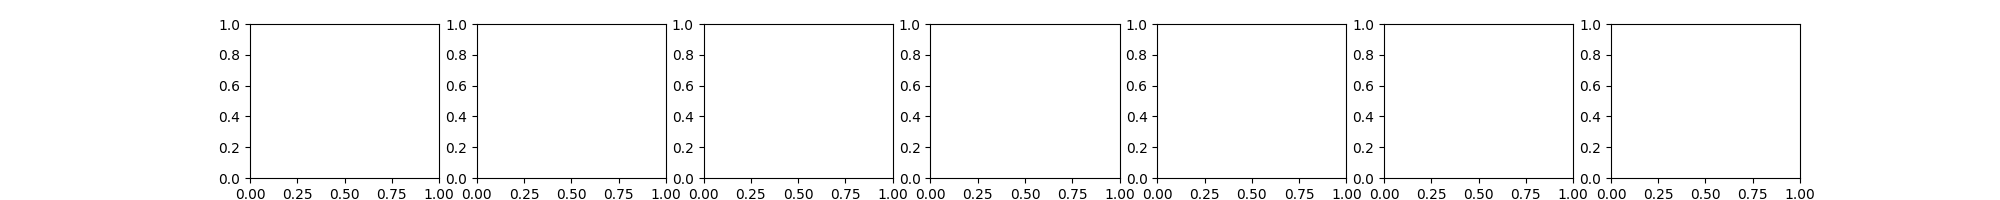

In [29]:
def plot_map_and_scatter(
    data_dict: dict, dd: int = 10, variable_names: list = test_dataset.features
):
    """
    Function to create 2 interactive subplots with ipyleaflet and ipywidgets.
    The input of the function is a dictionary with as keys the lat and lon of the points (formatted as a string like f'{lat}_{lon}') and as values a 2d numpy array with shape (N, 2) being N a variable quantity.
    In the first plot there is a map with markers extracted from the dictionary keys. When clicked on a marker, the second plot is updated with the corresponding data.
    The second plot is a scatter plot with the data from the dictionary values. The x axis is the first column of the array and the y axis is the second column of the array.
    """
    center_map_x, center_map_y = (list(data_dict.keys())[0]).split("_")
    shape_plots = (list(data_dict.values())[0]).shape
    # create the map
    m = ipyleaflet.Map(
        center=(float(center_map_y), float(center_map_x)),
        zoom=4,
        scroll_wheel_zoom=True,
    )
    # create the scatter plot
    output = ipywidgets.Output()
    with output:
        fig, axs = plt.subplots(1, shape_plots[1], figsize=(20, 2))
        for it, ax in enumerate(axs):
            ax.set_xlabel(variable_names[it])

        # ax = fig.add_subplot(1, 1, 1)
    # create the widget
    w = ipywidgets.Dropdown(options=list(data_dict.keys()), description="Select")

    # create the function that will be called when a marker is clicked
    def onclick(event, widget=w, data=data_dict, type=None, coordinates=None):
        with output:
            # get the lat and lon of the clicked marker
            lat, lon = coordinates
            # get the data corresponding to the clicked marker
            data_to_plot = data[f"{lon}_{lat}"]
            # update the scatter plot
            for it, ax in enumerate(axs):
                ax.clear()
                ax.scatter(data_to_plot[0, it, :], data_to_plot[1, it, :])
                ax.set_xlabel(variable_names[it])
            fig.tight_layout()
            fig.canvas.draw()
        # remove the rectangle from the map
        for layer in m.layers:
            if isinstance(layer, ipyleaflet.Rectangle):
                m.remove_layer(layer)
        # create a rectangle around the clicked marker
        rect = ipyleaflet.Rectangle(
            # bounds=((52, 354), (53, 360)),
            bounds=(
                (
                    lat - dd * 0.25,
                    lon - dd * 0.25,
                ),
                (lat + dd * 0.25, lon + dd * 0.25),
            ),
            # color="red",
            # fill_color="red",
        )
        # update the map
        m.add_layer(rect)
        m.center = (lat, lon)

    # create the markers
    for lon_lat, data in data_dict.items():
        lon, lat = lon_lat.split("_")
        # add the marker to the map with a fire icon
        marker = ipyleaflet.Marker(
            location=(float(lat), float(lon)),
            icon=ipyleaflet.Icon(
                icon_url="https://www.pngarts.com/files/10/Fire-Emoji-PNG-Transparent-Image.png",
                icon_size=[25, 35],
            ),
            draggable=False,
        )
        marker.on_click(onclick)
        m.add_layer(marker)
    # display the widget and the map
    display(ipywidgets.VBox([m, output]))
    return m, output


########################################################################################
# TEST:
# data_dict = {
#     "9_0": np.random.rand(10, 2),
#     "9_1": np.random.rand(10, 2),
#     "9_7": np.random.rand(10, 2),
# }
# m, out = plot_map_and_scatter(data_dict)
# m
########################################################################################

m, out = plot_map_and_scatter(dict_tot)
# compute the biome and the prediction for the selected path
xrpreds = xr.DataArray(np.where(target == -2, np.nan, target), coords=lb.coords)
io_biomes, acc_web1 = from_xarray_to_ImageOverlay(lb)
io_preds, acc_web2 = from_xarray_to_ImageOverlay(
    xrpreds, colormap=plt.cm.PuRd, repl_value=2
)
# add everything to the map
tile = basemap_to_tiles(basemaps.Esri.WorldStreetMap)
m.add(tile)  # add Esri World Street Map
m.add(io_biomes)  # add the Biomes
# m.add(io_preds) # add the predictions
io_biomes.interact(opacity=(1.0, 1.0, 0.01))